In this notebook I will demonstrate how to design a metasurface polarization grating and write it out as a CAD file (.gds) based on a pre-compiled library of metasurface unit elements. First, we import the relevant code which has to be in the same directory as your code or added to your Python path.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Core.polarization_gratings as pg

### Declaring the number of structures and instantiating the grating object.

The first step in designing the grating is to decide how many "pillar" elements will comprise the unit cell of the metasurface diffraction grating along the $x$ and $y$ directions, denoted $N_x$ and $N_y$. This decision is informed by what should be the angular separation of the diffraction orders along the $x$ and $y$ directions. In particular, we will have


$$
\theta_x = \arcsin\frac{\lambda_0}{N_x d_x}
$$

and

$$
\theta_y = \arcsin\frac{\lambda_0}{N_y d_y}
$$

where $\lambda_0$ is the free-space operating wavelength and $d_x$ and $d_y$ are the spacings between pillars along the $x$ and $y$ directions. These choices will be informed by design.

In what follows, we will just assume that $N_x=N_y=11$. Based on this choice, we instantiate a <code>grating</code> object.

In [2]:
Nx, Ny = 11, 11

grating = pg.MetasurfaceGratingUnitCell(Nx, Ny)

### Define the set of desired orders and for which polarization states they should analyze

Next, we declare the set of diffraction orders we are interested in; we declare these as a list of grating orders denoted by their indices $(m,n)$ numbered from the zero order of the diffraction grating.

Next, we define the polarization states for which these diffraction orders should act as analyzers. We declare these polarization states as Jones vectors and correspond in order to the diffraction orders declared in <code>orders</code>. For instance, the order (0, -1) here will be optimized in what follows to serve as a polarizer that prefers the state with a Jones vector given by <code>[1/np.sqrt(2),1j*1/np.sqrt(2)]</code> (circular polarization).

In [3]:
orders = [(1, 0), (-1, 0), (0, 1), (0, -1)] # set of diffraction orders of interest; innermost four orders in this case
# Jones vectors of states these should analyze
# These match the tetrahedron set from the paper, with the last one circular
polarizations =  np.array([ [0.514099,0.794104 -0.324192*1j],\
                           [0.985599, -0.169102*1j],\
                           [0.514099, -0.794104 -0.324192*1j] ,\
                           [1/np.sqrt(2),1j*1/np.sqrt(2)]] , dtype=complex)

### Compute the weight matrices

Rather than using an FFT, the code computes the Jones matrix-valued Fourier transforms analytically; this is sped up internally by computing what I call the "weight matrices" for the diffraction orders of interest ahead-of-time. You don't need to worry about this very much but it has to be done once.

In [4]:
weight_matrices = grating.compute_weight_matrices(orders)

### Define the merit function and constraints

The code as-written is completely general - we could optimize almost anything about the grating under any constraints, so long as we can define these as simple functions of the <code>state_vec</code> which contains all of the phase shifts $\phi_x$, $\phi_y$ and orientations $\theta$ for each pillar in the $N_x\times N_y$ grid.

The merit function <code>power_merit_function</code> defined below matches what was done in the paper - specifically, it optimizes the power in the orders of interest (averaged over all possible incident polarization states, i.e., the power in the desired orders for unpolarized incident light). The constraints defined here are also the same used in the paper. The constraint defined by <code>no_variability_constraint</code> attempts to enforce our desire that the average power of the orders should be identical (their standard deviation should be 0). The second constraint <code>contrast_constraint</code> is the workhorse that makes the grating do what we want - in it, we are coaxing the contrast or diattenuation of the diffraction orders to be as close to 1 as possible for the polarizations we specified.

This is how it was done in the *Science* paper but the code is general; many different combinations of merit functions and constraints could be tried.

In [5]:
# negative sign because optimizer minimizes
def power_merit_function(state_vec):
    return -np.sum(grating.power_in_orders_fast(orders, weight_matrices, state_vec))

# compute the standard deviation of the expected power in the orders of interest
def no_variability_constraint(state_vec):
    return np.std(grating.power_in_orders_fast(orders, weight_matrices, state_vec))

# compute the mean of the contrast in each order, minus 1
def contrast_constraint(state_vec):
    return (np.mean(grating.order_contrasts_fast(orders, polarizations, weight_matrices, state_vec)) - 1)

merit_func = power_merit_function # we use minimize, not maximize
cons = [no_variability_constraint, contrast_constraint] # list of constraints

# internally, my code is using scipy.minimize
# we have to declare constraints as equality or inequality constraints
# these are equality constraints, they should equal 0
cons_type = ['eq', 'eq']

### Run the optimization

Now, we are ready to optimize the parameters of the grating to design our polarization grating. We call the grating object's internal <code>optimize</code> command and pass in the constraints. The <code>tolerance</code> argument gives the residual of the merit function at which the optimization stops. Start with large tolerances and decrease and re-optimize. You can run the code many times with different tolerance values without overwriting anything - the grating object is storing the entire history of all optimization done on it, so if you optimize it again it starts where it left off from the previous optimization. When called initially, the <code>grating</code> object stores a random initial condition from which the optimization begins.

The merit function being displayed in this case is the power in the orders of interest divided by the power in all transmitted orders.

In [6]:
output_power = grating.optimize(merit_func, cons, cons_type, tolerance=0.0001)

Iteration:  1  - Merit = 0.05565965457865001
Iteration:  2  - Merit = 0.09383886810511806
Iteration:  3  - Merit = 0.11093629722232456
Iteration:  4  - Merit = 0.12107452403100064
Iteration:  5  - Merit = 0.13145491799477343
Iteration:  6  - Merit = 0.143768340740982
Iteration:  7  - Merit = 0.14766223904719938
Iteration:  8  - Merit = 0.14870826234223064
Iteration:  9  - Merit = 0.1498004317161855
Iteration:  10  - Merit = 0.15184803755838028
Iteration:  11  - Merit = 0.15455594773449083
Iteration:  12  - Merit = 0.157816717613765
Iteration:  13  - Merit = 0.15948631928757004
Iteration:  14  - Merit = 0.16100578058582918
Iteration:  15  - Merit = 0.16428067489126794
Iteration:  16  - Merit = 0.16742010110969835
Iteration:  17  - Merit = 0.17589414700599862
Iteration:  18  - Merit = 0.19664092143509743
Iteration:  19  - Merit = 0.2294366100382858
Iteration:  20  - Merit = 0.29555179577680324
Iteration:  21  - Merit = 0.26966969064512814
Iteration:  22  - Merit = 0.32694574094481255
Ite

### Saving the grating

There is a built-in save method; it saves two files: a file containing the grating object and a second for its history. There is also a built-in <code>load</code> command to load that same two files later into a <code>grating</code> object later to continue working with it.

In [7]:
grating.save('Grating Designs/eleven_element_grating_test.npz')

# this would be the command to load a previously saved grating into the grating object
# grating.load('Grating Designs/eleven_element_grating_test.npz')

### Analyzing our optimized result

We can analyze the optimized result to see the power numerically predicted by the Fourier optics model in all of the diffraction orders.

Text(0, 0.5, 'n')

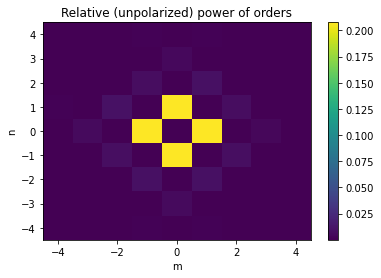

In [8]:
# extract the final parameters
phi_x, phi_y, theta = grating.phi_x, grating.phi_y, grating.theta

# pack these into a final 'state vector'
final_state = grating.pack(phi_x, phi_y, theta)

# decide how many orders to plot
Nx_plotting, Ny_plotting = 4, 4

# instantiate empty arrays of complex numbers
Js = np.zeros([2*Nx_plotting+1, 2*Ny_plotting+1, 2, 2], dtype=complex)
pwr = np.zeros([2*Nx_plotting+1, 2*Ny_plotting+1], dtype=complex)

# get list of orders
orders_x = np.arange(-Nx_plotting, +Nx_plotting+1)
orders_y = np.arange(-Ny_plotting, +Ny_plotting+1)

# iterate over orders and compute power
for i in range(len(orders_x)):
    for j in range(len(orders_y)):
        m, n = orders_x[i], orders_y[j]
        weight_matrix = grating.calculate_weight_matrix(m,n)
        J = grating.calculate_Jmn_fast(m,n,weight_matrix,final_state) # find Jones matrix of diffraction order
        Js[i,j,:,:] = J
        pwr[i,j] = 0.5 * np.trace(np.conj(J).T @ J) # average power is 0.5 * (J^dagger J)

# plot the result
M, N = np.meshgrid(orders_x, orders_y)    
plt.pcolormesh(M, N, np.abs(pwr), shading='auto')
plt.colorbar()
plt.title('Relative (unpolarized) power of orders')
plt.xlabel('m')
plt.ylabel('n')

We can use this same information to view the map of order powers when the different preferred polarization states are incident, demonstrating the designed polarization selectivity of the diffraction orders as in Fig. 11 of the supplemental information.

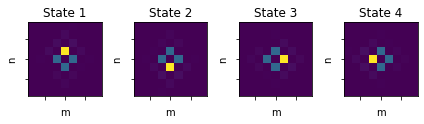

In [9]:
size = Js.shape
output_powers = np.zeros([size[0], size[1], len(polarizations)]) # array to store output powers

# for each designed polarization state
for polarization, i in zip(polarizations, range(len(polarizations))):
    output_pol = Js@polarization # find the output Jones vector on each order using Jones matrices computed above
    output_powers[:, :, i] = np.linalg.norm(output_pol, axis=2)**2 # compute the intensity on each order

# plot the results
fig, axs = plt.subplots(1, len(polarizations))
for i in range(len(polarizations)):
    ax = axs[i]
    ax.pcolormesh(M, N, output_powers[:, :, i], shading='auto')
    ax.set_title('State ' + str(i+1))
    ax.set_xlabel('m')
    ax.set_ylabel('n')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
fig.tight_layout()

We can also compare the polarization ellipses realized numerically in the optimization to those desired at the outset. The top row are the desired ellipses and the bottom row are the ones that are predicted by the Jones matrix Fourier optics formalism.

To do this we use some helpful polarization functions provided.

Text(0.5, 0.98, 'Desired (top) vs. realized (bottom) polarization analyzer states')

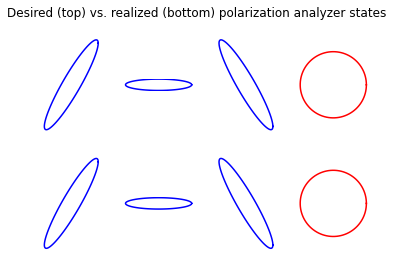

In [10]:
import Core.helpful_polarization_functions as pol

desired_polarizations = [pol.jones_to_stokes(jones) for jones in polarizations]

jones_matrices = np.zeros([len(orders), 2, 2], dtype=complex)

for i, order in zip(range(len(orders)), orders):
    m, n = order
    weight_matrix = grating.calculate_weight_matrix(m,n)
    J = grating.calculate_Jmn_fast(m,n,weight_matrix,final_state) # find Jones matrix of diffraction order
    jones_matrices[i, :, :] = J
    
mueller_matrices = [pol.jones_mueller(jones_matrix) for jones_matrix in jones_matrices]
realized_analyzer_states = [pol.stokes_to_jones(mueller_matrix[0, 1:]) for mueller_matrix in mueller_matrices]

fig, axs = plt.subplots(2, 4)

for i in range(len(polarizations)):
    pol.plot_polarization_ellipse(axs[0,i], polarizations[i])
    pol.plot_polarization_ellipse(axs[1,i], realized_analyzer_states[i])
    
fig.suptitle('Desired (top) vs. realized (bottom) polarization analyzer states')

We can also extract the diattenuation from the Mueller matrices.

In [11]:
diattenuation = [np.sqrt(mueller[0,1]**2+mueller[0,2]**2+mueller[0,3]**2)/mueller[0,0] for mueller in mueller_matrices]
diattenuation

[0.9999999993233868,
 0.9999999953599483,
 0.9999999990622025,
 0.9999999971248837]

### Creating a CAD version of the grating

So far, the metasurface polarization grating has been described as a purely mathematical object. We haven't even made any reference in the design process to the wavelength of light being used.

Next, as described in the paper, we find a best-fit physical implementation corresponding to the design by referring to a library of structures. I have included several such libraries of pillars simulated at different wavelengths as a part of this code library. If you need to generate a new one at a different wavelength using, e.g., Lumerical, feel free to ask me.

In [12]:
# location of pillar library to load
# the example here is a library of TiO2 rectangles for use at 550 nm
library_file = 'Pillar libraries\\550 nm TiO2\\library_550_lumerical_denser_2020_06.mat'
library_dict = pg.load_simulation_library(library_file)

# find the design by lookup table for the given library
# you can specify a minimum size to use, so that your features are not too small for fabrication
# N_offset acknowledges that the phase shifts found in optimization can be shifted up or down arbitrarily
# N_offset different shifts are tried to find the best fit to the library
# this step can take a little while if the grating is large
# min_size is the minimum acceptable feature size in nm
design = grating.get_unitcell_design_offset(library_dict,min_size=50,N_offset=1000)

Next, we can actually write out the CAD to a <code>.gds</code> file.

(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': 'Grating design'}, xlabel='x (μm)', ylabel='y (μm)'>)

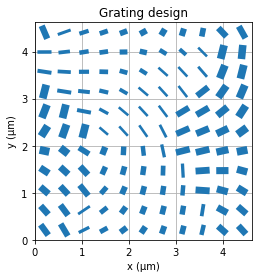

In [13]:
size_x = 3100 # in microns
size_y = 3100

filename = 'test_gds.gds'

# separation in microns between pillar elements
# this is chosen in accordance with whatever the desired grating angle will be, as discussed above
separation = 0.420

# generate and save the CAD file as a .gds file
# size_offset is a size subtracted from all dimensions, if desired, in nm
# open the gds with, e.g., KLayout
grating.get_cad(size_x, size_y, filename, design, separation, size_offset=0)

grating.plot_design(design, separation)